# Introduction
The purpose of the project is to find similars cryptos that can be used for pairs trading strategy. Although the project aims at finding cryptos that behave in a same fashion over a certain period of time but the code can be use for any timeseries with minor alterations

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
import scipy
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn import metrics
from tslearn.utils import to_time_series_dataset


/Users/vachananand/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


We start by loading the data to a pandas dataframe. The downloadinded from binance using Binance's python api. To download the data for your project you can have a look at : https://github.com/VachanAnand/Binance_utils/blob/main/DownloadFuturesData.ipynb  

For the purpose of this notebook the data was downloaded and saved into csv files. 

In [2]:
close_df = pd.read_csv("close-1h.csv")


In [3]:
close_df.head()

,EOSUSDT,SUSHIUSDT,BALUSDT,KNCUSDT,SRMUSDT,ENJUSDT,ZRXUSDT,QTUMUSDT,ATOMUSDT,IOTAUSDT,...,SXPUSDT,CRVUSDT,DOTUSDT,EGLDUSDT,VETUSDT,ONTUSDT,TRBUSDT,ZILUSDT,LENDUSDT,FLMUSDT
0,2.572,1.2795,15.630,0.98270,1.7582,0.16217,0.3976,2.420,5.520,0.2790,...,1.6800,0.937,4.332,10.269,0.013106,0.6261,22.806,0.01869,0.5339,0.6268
1,2.578,1.2831,15.876,0.98817,1.7658,0.16296,0.4022,2.463,5.480,0.2799,...,1.6945,0.936,4.340,10.429,0.013400,0.6312,22.931,0.01862,0.5349,0.6304
2,2.582,1.2958,15.683,0.98919,1.7583,0.16265,0.4023,2.462,5.413,0.2801,...,1.7213,0.949,4.333,10.596,0.013277,0.6285,23.031,0.01892,0.5267,0.6087
3,2.578,1.2903,15.518,0.99035,1.7462,0.16184,0.4020,2.444,5.406,0.2787,...,1.7069,0.950,4.296,10.496,0.013278,0.6259,22.508,0.01869,0.5223,0.6081
4,2.567,1.2833,15.363,0.98811,1.7478,0.16041,0.4025,2.416,5.367,0.2752,...,1.6664,0.941,4.288,10.448,0.013044,0.6195,22.445,0.01859,0.5209,0.6028


# Dynamic Time Warping

Whenever we think of clustering, we generally think of euclidean distance as a matrix to define similarity between two observations. Euclidean distance works well for most of the cases but when it comes to time series the performance takes a hit due to properties of time series.  

Here's a link to a blog that might help you understand why distance metric matter while clustering time series data. http://alexminnaar.com/2014/04/16/Time-Series-Classification-and-Clustering-with-Python.html

Therfore for time series anlysis we use DTW (dynamic time wrapping to find distance/similarity between two time series). DTW is a more sophisticated measure of simiratity that works by summing up minimum distance between a point in time series and any other point in another time series to calculate the closest point between any two time series. 


Let's the two methods to understand the difeerence


In [4]:
def euclidean_dist(x,y):
    return np.sum(np.square(x - y)) 


In [5]:
x = np.arange(0,20,0.1)
sinx = np.sin(x)
cosx = np.cos(x)


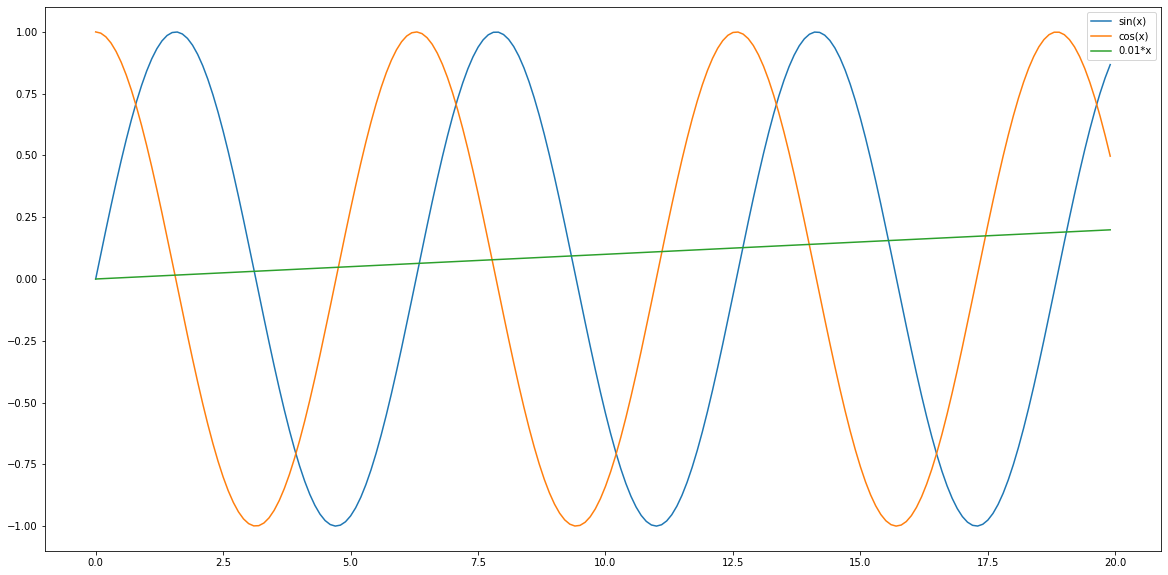

Euclidean Distance
sin(x) , cos(x) : 192.0656671121971
sin(x) , 0.01*x : 102.00421151648698


In [6]:
plt.figure(figsize=(20,10))
plt.plot(x,sinx)
plt.plot(x,cosx)
plt.plot(x,0.01*x)
plt.legend(["sin(x)","cos(x)","0.01*x"])
plt.show()
print("Euclidean Distance")
print("sin(x) , cos(x) :",euclidean_dist(sinx,cosx))
print("sin(x) , 0.01*x :",euclidean_dist(sinx,0.01*x))

From the graph above if we had to make a call for the two similar time series we'd say that the sine function is more similar to cosise function than it is to the straight line 0.01*x. 


However if we calculate euclidiean distance amongst the three series we find that the blue line sin(x) has a lower euclidean distance to the green line than to orange line cos(x). Hence the problem. 


Now let's have a look at DTW to find similar time series. DTW can be impleented using recursion but for ease of understanding and use we have a package [tslearn](https://tslearn.readthedocs.io/en/stable/index.html) that can be used for time series analysis


In [7]:
def get_dtw(x,y):
    return metrics.dtw(x,y)

In [8]:
print("DTW Distance")
print("sin(x) , cos(x) :",get_dtw(sinx,cosx))
print("sin(x) , 0.01*x :",get_dtw(sinx,0.01*x))

DTW Distance
sin(x) , cos(x) : 2.004758571406816
sin(x) , 0.01*x : 9.803162822398997


Here, we can see that DTW metrics gives a better or more reasonable distance for the time series than the eucliden distance. Hence we'll carry forward the clustering using DTW metrics

# Clustering
Before we start clustering we need to find the most appropriate data to maximise the benifits of using this algorithm. Since in this instance we are using clustering on cryto timeseries, one of the most frequently used data from such analysis is close price data. 

In [9]:
close_df = pd.read_csv("close-1h.csv")
close_df.shape

(711, 62)

In [10]:
close_df.head()

,EOSUSDT,SUSHIUSDT,BALUSDT,KNCUSDT,SRMUSDT,ENJUSDT,ZRXUSDT,QTUMUSDT,ATOMUSDT,IOTAUSDT,...,SXPUSDT,CRVUSDT,DOTUSDT,EGLDUSDT,VETUSDT,ONTUSDT,TRBUSDT,ZILUSDT,LENDUSDT,FLMUSDT
0,2.572,1.2795,15.630,0.98270,1.7582,0.16217,0.3976,2.420,5.520,0.2790,...,1.6800,0.937,4.332,10.269,0.013106,0.6261,22.806,0.01869,0.5339,0.6268
1,2.578,1.2831,15.876,0.98817,1.7658,0.16296,0.4022,2.463,5.480,0.2799,...,1.6945,0.936,4.340,10.429,0.013400,0.6312,22.931,0.01862,0.5349,0.6304
2,2.582,1.2958,15.683,0.98919,1.7583,0.16265,0.4023,2.462,5.413,0.2801,...,1.7213,0.949,4.333,10.596,0.013277,0.6285,23.031,0.01892,0.5267,0.6087
3,2.578,1.2903,15.518,0.99035,1.7462,0.16184,0.4020,2.444,5.406,0.2787,...,1.7069,0.950,4.296,10.496,0.013278,0.6259,22.508,0.01869,0.5223,0.6081
4,2.567,1.2833,15.363,0.98811,1.7478,0.16041,0.4025,2.416,5.367,0.2752,...,1.6664,0.941,4.288,10.448,0.013044,0.6195,22.445,0.01859,0.5209,0.6028


Here we have dataframe of close prices for 44 crytops for a period of almost 2 months on a 1 hour candlestick chart

In [11]:
def get_clusters(data,num_clusters):
    X = to_time_series_dataset(data.T.values)
    X_train = TimeSeriesScalerMeanVariance().fit_transform(X)
    k_means = TimeSeriesKMeans(n_clusters=num_clusters,
                                metric="dtw",
                                n_init = 5,
                                verbose=False,
                                random_state= 1)
    y_pred = k_means.fit_predict(X_train)
    return y_pred,k_means


In [12]:
def calc_intra_distance(k_means,data,y_pred,num_clusters):
    dist = dict()
    X = to_time_series_dataset(data.T.values)
    X_train = TimeSeriesScalerMeanVariance().fit_transform(X)
    for yi in range(num_clusters):
        dist["C"+str(yi)] = 0
        centroid = k_means.cluster_centers_[yi].ravel()
        for xx in X_train[y_pred == yi]:
            xi = xx.ravel()
            dist["C"+str(yi)] += get_dtw(xi,centroid)
    return dist

In [13]:
num_clusters = 3

In [14]:
y_pred,k_means = get_clusters(close_df,num_clusters)
dist = calc_intra_distance(k_means,close_df,y_pred,num_clusters)


In [15]:
for i in range(num_clusters):
    print(f"Cluster {i+1} :",list(close_df.columns[y_pred==i]))
    print("\n")

Cluster 1 : ['SUSHIUSDT', 'BALUSDT', 'SRMUSDT', 'QTUMUSDT', 'HNTUSDT', 'YFIUSDT', 'BZRXUSDT', 'BATUSDT', 'ALGOUSDT', 'SNXUSDT', 'NEOUSDT', 'UNIUSDT', 'DEFIUSDT', 'COMPUSDT', 'SOLUSDT', 'OMGUSDT', 'ICXUSDT', 'FTMUSDT', 'YFIIUSDT', 'SXPUSDT', 'CRVUSDT', 'EGLDUSDT', 'VETUSDT', 'ONTUSDT', 'LENDUSDT', 'FLMUSDT']


Cluster 2 : ['EOSUSDT', 'WAVESUSDT', 'BCHUSDT', 'BNBUSDT', 'ETCUSDT', 'XMRUSDT', 'ETHUSDT', 'DOGEUSDT', 'TRXUSDT', 'XLMUSDT', 'DASHUSDT', 'LINKUSDT', 'BTCUSDT', 'LTCUSDT', 'XRPUSDT', 'DOTUSDT', 'TRBUSDT']


Cluster 3 : ['KNCUSDT', 'ENJUSDT', 'ZRXUSDT', 'ATOMUSDT', 'IOTAUSDT', 'ADAUSDT', 'XTZUSDT', 'IOSTUSDT', 'ZECUSDT', 'RLCUSDT', 'STORJUSDT', 'AVAXUSDT', 'MKRUSDT', 'THETAUSDT', 'KAVAUSDT', 'RUNEUSDT', 'BLZUSDT', 'BANDUSDT', 'ZILUSDT']




We can see the evident difference between the clusters using different methods. Let's try to visualise the difference to get a better idea.

In [16]:
def plot_clusters(cluster_obj,data,predictions,num_clusters):
    plt.figure(figsize=(20,10))
    X = to_time_series_dataset(data.T.values)
    X = TimeSeriesScalerMeanVariance().fit_transform(X)
    for cluster_no in range(num_clusters):
        plt.subplot(3, 3, cluster_no + 1)
        for x_clusters in X[predictions == cluster_no]:
            plt.plot(x_clusters.ravel(), "k-", alpha=.2)
        plt.plot(cluster_obj.cluster_centers_[cluster_no].ravel(), "r-")
        plt.text(0.55, 0.85,'Cluster %d' % (cluster_no + 1),
                 transform=plt.gca().transAxes)




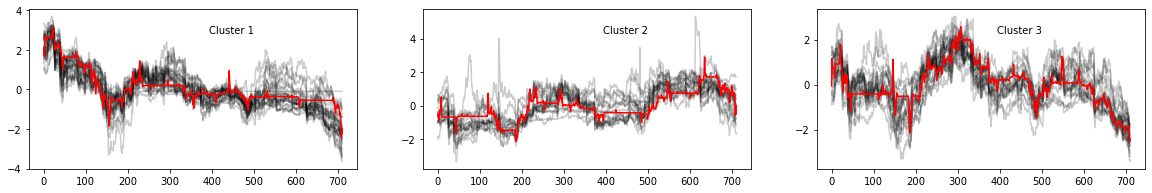

In [17]:
plot_clusters(k_means,close_df,y_pred,num_clusters)

Now that we know how to perform K means clusterring on a simple time series data, let's try to find the optimal number of clusters in this timeseries. There are essentially two basic methods to find the number of clusters for K means. 
- First, we can try to reduce the sum of intra cluster distance ( the sum of distance between the timeseries and the centroid) among all clusters and then set the cluster to n after which there is no significat decerese in this distance
- Secondly, incase the first method fails due to consistent decrese in intra-cluster distance we can specify the number of clusters based on our needs. For the purpose of pairs trading since we are looking to find 15 pairs, lets check if we can divide the crytops in 15 clusters and then choose pairs from within those clusters 

In [18]:
def get_cluster_loss():
    dist_sum = list()
    for num_clusters in range(2,10):
        print("CLUSTER NO.",num_clusters)
        y_pred,k_means = get_clusters(close_df,num_clusters)
        dist = calc_intra_distance(k_means,close_df,y_pred,num_clusters)
        print("Distance",sum(dist.values()))
        print("\n")
        dist_sum.append(sum(dist.values()))
    return dist_sum

In [19]:
dist_sum = get_cluster_loss()

CLUSTER NO. 2
Distance 362.2065110743565


CLUSTER NO. 3
Distance 321.8344990182095


CLUSTER NO. 4
Distance 297.4700524424722


CLUSTER NO. 5
Distance 287.5136397550399


CLUSTER NO. 6
Distance 270.70047081213676


CLUSTER NO. 7
Distance 263.0236488781604


CLUSTER NO. 8
Distance 249.29289782370532


CLUSTER NO. 9
Distance 242.26517055503095




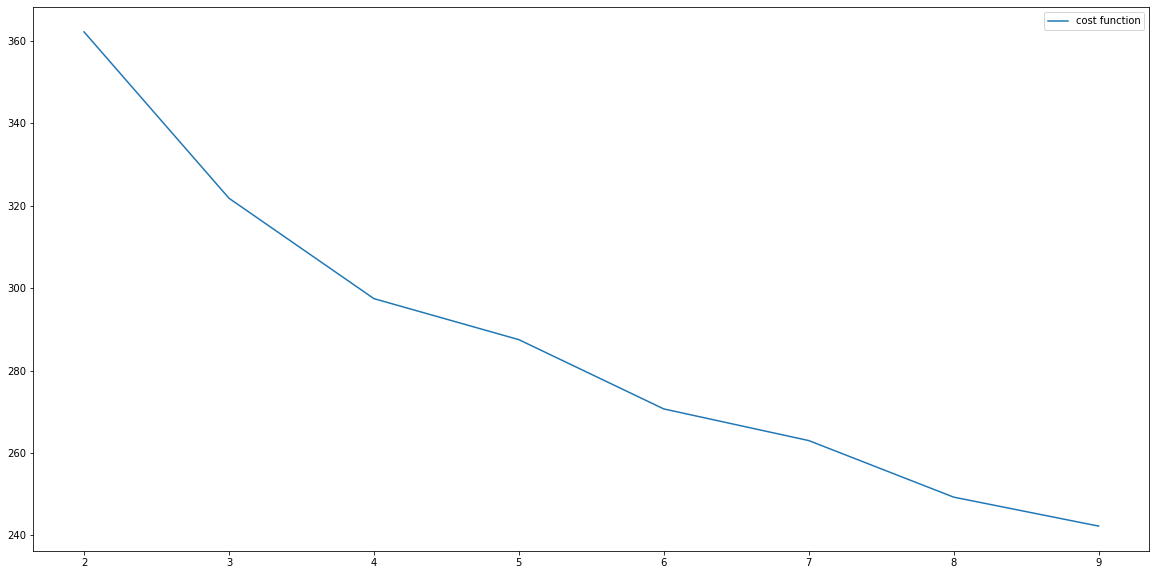

In [20]:
plt.figure(figsize=(20,10))
plt.plot(range(2,10),dist_sum)
plt.legend(["cost function"])

As we can see that the first method has faild as the cost function (intra-cluster distance) is consistently decreasing, and there is no evident elbow formation, let's try to find cluster based on our needs

In [21]:
num_clusters = 15


In [22]:
y_pred,k_means = get_clusters(close_df,num_clusters)


In [23]:
for i in range(15):
    print(f"Cluster {i+1} :",list(close_df.columns[y_pred==i]))
    print("\n")

Cluster 1 : ['KNCUSDT', 'QTUMUSDT', 'IOSTUSDT', 'BATUSDT', 'ALGOUSDT', 'NEOUSDT']


Cluster 2 : ['WAVESUSDT', 'BCHUSDT', 'ETHUSDT', 'XLMUSDT', 'LINKUSDT', 'BTCUSDT', 'LTCUSDT']


Cluster 3 : ['BALUSDT', 'HNTUSDT', 'YFIUSDT', 'SNXUSDT', 'SOLUSDT', 'FTMUSDT', 'SXPUSDT', 'ONTUSDT']


Cluster 4 : ['IOTAUSDT', 'TRXUSDT', 'MKRUSDT']


Cluster 5 : ['LENDUSDT']


Cluster 6 : ['ATOMUSDT', 'XTZUSDT', 'ZECUSDT', 'RUNEUSDT']


Cluster 7 : ['ENJUSDT', 'STORJUSDT', 'THETAUSDT', 'KAVAUSDT', 'BLZUSDT']


Cluster 8 : ['ETCUSDT', 'DASHUSDT', 'DOTUSDT', 'TRBUSDT']


Cluster 9 : ['DEFIUSDT', 'COMPUSDT', 'OMGUSDT', 'ICXUSDT', 'VETUSDT']


Cluster 10 : ['SUSHIUSDT', 'SRMUSDT', 'BZRXUSDT', 'UNIUSDT', 'YFIIUSDT', 'CRVUSDT', 'EGLDUSDT', 'FLMUSDT']


Cluster 11 : ['ZRXUSDT', 'RLCUSDT', 'AVAXUSDT', 'BANDUSDT']


Cluster 12 : ['EOSUSDT']


Cluster 13 : ['DOGEUSDT']


Cluster 14 : ['ZILUSDT']


Cluster 15 : ['ADAUSDT', 'BNBUSDT', 'XMRUSDT', 'XRPUSDT']




Now that we have the clusters, we can start sort pairs for the pairs trading strategy. We can cointigration and mean reversion tests to cofirm pairs.

In [24]:
def get_ab_thielsen(S1,S2):
    beta,alpha,_,_ = scipy.stats.mstats.theilslopes(S1,S2)
    return alpha,beta


In [25]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs_coint = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs_coint.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs_coint

def find_meanReverting_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs_adf = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            alpha,beta = get_ab_thielsen(S1,S2)
            spread = (S1 -(beta*S2)-alpha)
            result = adfuller(spread)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs_adf.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs_adf


In [26]:
clusters = list()
for i in range(num_clusters):
    clusters.append(list(close_df.columns[y_pred==i]))

In [27]:
all_common = list()
for cluster_no in range(len(clusters)):
    df = close_df[clusters[cluster_no]]
    score_matrix, pvalue_matrix,pairs_coint = find_cointegrated_pairs(df)
    score_matrix, pvalue_matrix, pairs_meanrev = find_meanReverting_pairs(df.astype(float))
    common = set(pairs_coint).intersection(set(pairs_meanrev))
    if len(common) > 0 :
        print(f"CLUSTER {cluster_no}")
        print(f"Pairs :{common} \n")


CLUSTER 0
Pairs :{('QTUMUSDT', 'BATUSDT'), ('KNCUSDT', 'ALGOUSDT'), ('IOSTUSDT', 'ALGOUSDT'), ('KNCUSDT', 'QTUMUSDT'), ('QTUMUSDT', 'ALGOUSDT'), ('KNCUSDT', 'IOSTUSDT')} 

CLUSTER 2
Pairs :{('SNXUSDT', 'FTMUSDT'), ('BALUSDT', 'FTMUSDT'), ('BALUSDT', 'YFIUSDT'), ('HNTUSDT', 'SNXUSDT'), ('SOLUSDT', 'FTMUSDT'), ('HNTUSDT', 'FTMUSDT'), ('SNXUSDT', 'SXPUSDT'), ('SNXUSDT', 'SOLUSDT'), ('BALUSDT', 'SXPUSDT'), ('FTMUSDT', 'SXPUSDT'), ('BALUSDT', 'SOLUSDT'), ('SOLUSDT', 'SXPUSDT')} 

CLUSTER 3
Pairs :{('IOTAUSDT', 'MKRUSDT')} 

CLUSTER 5
Pairs :{('XTZUSDT', 'ZECUSDT'), ('XTZUSDT', 'RUNEUSDT'), ('ATOMUSDT', 'RUNEUSDT'), ('ATOMUSDT', 'XTZUSDT')} 

CLUSTER 6
Pairs :{('ENJUSDT', 'STORJUSDT'), ('ENJUSDT', 'KAVAUSDT'), ('ENJUSDT', 'BLZUSDT'), ('THETAUSDT', 'BLZUSDT')} 

CLUSTER 7
Pairs :{('ETCUSDT', 'TRBUSDT')} 

CLUSTER 8
Pairs :{('DEFIUSDT', 'ICXUSDT'), ('OMGUSDT', 'ICXUSDT')} 

CLUSTER 10
Pairs :{('ZRXUSDT', 'BANDUSDT')} 

CLUSTER 14
Pairs :{('BNBUSDT', 'XMRUSDT')} 



# Final Note
Finally, we found pairs that belong in the same clusters. These pairs would have a tendancy to perform better than other pairs found using correlation or clutering using Euclidian metrics. 